In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR


from sklearn.model_selection import train_test_split

In [2]:
WINDOW_SIZE = 64
SLIDE_FACTOR = 0.3
BATCH_SIZE = 64

VALID_SIZE = 0.2
TEST_SIZE = 0.2

N_EPOCHS=60

Load the dataset

In [3]:
file_path = 'dataset/modis/fire_archive_M6_96619.csv'
dataset_f = pd.read_csv(file_path)
dataset_f.drop(['bright_t31'], axis=1, inplace=True)

dataset_f.head()

,latitude,longitude,brightness,confidence,frp,daynight,timestamp
0,-11.8070,142.0583,313.0,48,6.6,D,1564646160
1,-11.7924,142.0850,319.3,71,11.3,D,1564646160
2,-12.8398,132.8744,311.6,42,23.1,D,1564646220
3,-14.4306,143.3035,310.1,33,6.5,D,1564646220
4,-12.4953,131.4897,310.3,36,27.6,D,1564646220


## Prepare the dataset

We need to scale or convert to categorical the entire dataset

### Get some minimum/maximum values

In [4]:
# get some min/max values
bounds = {
    'latitude': {
        "max": dataset_f['latitude'].max(),
        "min": dataset_f['latitude'].min()
    },
    'longitude': {
        "max": dataset_f['longitude'].max(),
        "min": dataset_f['longitude'].min()
    },
    'brightness': {
        "max": dataset_f['brightness'].max(),
        "min": dataset_f['brightness'].min()
    },
    'confidence': {
        "max": dataset_f['confidence'].max(),
        "min": dataset_f['confidence'].min()
    },
    'timestamp': {
        "max": dataset_f['timestamp'].max(),
        "min": dataset_f['timestamp'].min()
    },
    'frp': {
        'max': dataset_f['frp'].max(),
        'min': dataset_f['frp'].min()
    }
}

print(bounds)

{'latitude': {'max': -10.0726, 'min': -42.7628}, 'longitude': {'max': 153.4904, 'min': 114.1043}, 'brightness': {'max': 504.4, 'min': 300.0}, 'confidence': {'max': 100, 'min': 0}, 'timestamp': {'max': 1569887100, 'min': 1564646160}, 'frp': {'max': 3679.5, 'min': 0.0}}


### Scale every column

In [5]:
# create a function to scale values into [0, 1]
def scale(x, max, min):
    return (x-min)  / (max-min)

In [6]:
# scale every column in the dataset
for col in dataset_f.columns:
    b = bounds.get(col)
    if b is not None:
        dataset_f[col] = dataset_f[col].apply(scale, args=(b['min'], b['max']))
        bounds[col] = {'max': 1.0, 'min':0.0}

In [7]:
dataset_f.head()

,latitude,longitude,brightness,confidence,frp,daynight,timestamp
0,0.053056,0.290257,0.936399,0.52,0.998206,D,1.000000
1,0.052609,0.289579,0.905577,0.29,0.996929,D,1.000000
2,0.084649,0.523433,0.943249,0.58,0.993722,D,0.999989
3,0.133312,0.258642,0.950587,0.67,0.998233,D,0.999989
4,0.074111,0.558590,0.949609,0.64,0.992499,D,0.999989


### Map daynight data to categorical

In [8]:
def create_map(df, col):
    unique_set = set(df[col].unique())
    return {key: i for i,key in enumerate(unique_set)}

daynight_map = create_map(dataset_f, "daynight")
dataset_f['daynight'] = dataset_f['daynight'].map(daynight_map).fillna(dataset_f['daynight'])
dataset_f.head(10)

,latitude,longitude,brightness,confidence,frp,daynight,timestamp
0,0.053056,0.290257,0.936399,0.52,0.998206,0,1.000000
1,0.052609,0.289579,0.905577,0.29,0.996929,0,1.000000
2,0.084649,0.523433,0.943249,0.58,0.993722,0,0.999989
3,0.133312,0.258642,0.950587,0.67,0.998233,0,0.999989
4,0.074111,0.558590,0.949609,0.64,0.992499,0,0.999989
5,0.077898,0.286665,0.927593,0.32,0.997472,0,0.999989
6,0.131321,0.251921,0.973581,0.76,0.998397,0,0.999989
7,0.129914,0.253150,0.887965,0.21,0.994456,0,0.999989
8,0.094609,0.292461,0.915851,0.28,0.997309,0,0.999989
9,0.045111,0.528379,0.943738,0.60,0.992581,0,0.999989


## Split into sequences of inputs and labels
We try to predict the *average* of the next 5 events. Thus, the label for each event should be the next 5 events.

In [9]:
def xy_split(df):
    dset_x = []
    dset_y = []
    for i in range(df.shape[0]-5):
        dset_x.append(df.loc[i])
        dset_y.append(df.loc[i:i+4].to_numpy(dtype=np.float32))

    dset_x = np.array(dset_x)
    dset_y = np.array(dset_y)

    return dset_x, dset_y

dset_x, dset_y = xy_split(dataset_f)

sequence_x = []
sequence_y = []
for i in range(0, dset_x.shape[0]-WINDOW_SIZE, int(WINDOW_SIZE*SLIDE_FACTOR)):
    sequence_x.append(dset_x[i:i+WINDOW_SIZE])
    sequence_y.append(dset_y[i:i+WINDOW_SIZE])

sequence_x = np.array(sequence_x)
sequence_y = np.array(sequence_y)

print(f'{sequence_x.shape=}, {sequence_y.shape=}')
sequences = np.concatenate([sequence_x[:,:,None,:], sequence_y[:,:,:,:]], axis=2)

sequence_x.shape=(1892, 64, 7), sequence_y.shape=(1892, 64, 5, 7)


## Split into training, validation, and testing

In [10]:
train, t2 = train_test_split(sequences, shuffle=False, test_size=(TEST_SIZE+VALID_SIZE))
valid, test = train_test_split(t2, shuffle=False, test_size =TEST_SIZE / (TEST_SIZE+VALID_SIZE))

print(f'{train.shape=}, {valid.shape=}, {test.shape=}')

train.shape=(1135, 64, 6, 7), valid.shape=(378, 64, 6, 7), test.shape=(379, 64, 6, 7)


# Create the model

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

event_vec_dim = sequences.shape[-1]
seq_len = WINDOW_SIZE
hidden_dim = 1024
num_layers = 4

In [12]:
class FirePredictor(nn.Module):
    def __init__(self,  event_vec_dim, seq_len, hidden_dim, num_layers):
        super(FirePredictor, self).__init__()
        self.event_vec_dim = event_vec_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.seq_len = seq_len

        self.lstm = nn.LSTM(self.event_vec_dim, self.hidden_dim, num_layers = self.num_layers, batch_first=True, device=device)
        self.flatten = nn.Flatten()
        self.output = nn.Linear(hidden_dim*seq_len, event_vec_dim*seq_len, device=device)

    def forward(self, x):
        h1 = self.lstm(x)[0]
        flat = self.flatten(h1)
        return self.output(flat).reshape(x.shape[0], self.seq_len, self.event_vec_dim)

# create the model
model = FirePredictor(event_vec_dim, seq_len, hidden_dim, num_layers)

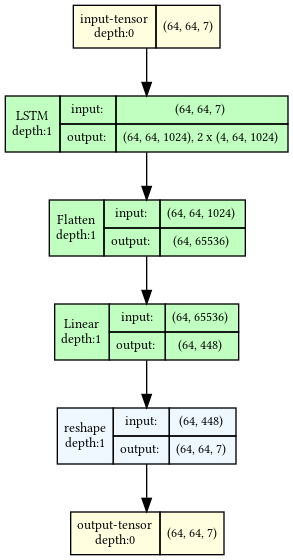

In [13]:
# visualize model structure
# This uses torchview, which is a library outside of pytorch for visualizing torch.nn.Modules
# https://github.com/mert-kurttutan/torchview
import graphviz
graphviz.set_jupyter_format('png')

from torchview import draw_graph
model_graph = draw_graph(model, input_size=(BATCH_SIZE, WINDOW_SIZE, event_vec_dim), device='cuda')
model_graph.visual_graph

## Write the loss function

In [14]:
def euclidean_dist(t1, t2, dim):
    return (t1 - t2).pow(2).sum(dim).sqrt()

def avg_distance(x, y):
    reshaped = x[:,:,None,:] * torch.ones_like(y)
    return (euclidean_dist(reshaped, y, dim=2)).sum() / (y.shape[0]*y.shape[1])


x = sequences[0:128,0:64,0,:]
y = sequences[0:128,0:64,1:,:]

avg_distance(torch.Tensor(x), torch.Tensor(y))

tensor(0.8615)

## Prepare Optimizer, Scheduler, and Data Loader

In [15]:
# split train & validation data into inputs and labels
x_train = torch.Tensor(train[:,:,0,:])
y_train = torch.Tensor(train[:,:,1:,:])

x_valid = torch.Tensor(valid[:,:,0,:]).to(device)
y_valid = torch.Tensor(valid[:,:,1:,:]).to(device)

In [16]:
print(f'{x_valid.shape=}, {y_valid.shape}')

x_valid.shape=torch.Size([378, 64, 7]), torch.Size([378, 64, 5, 7])


In [17]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

data_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BATCH_SIZE)

loss_function = avg_distance

## Training Loop

In [18]:
losses_train = np.zeros(N_EPOCHS)
losses_valid = np.zeros(N_EPOCHS)

for epoch in range(N_EPOCHS):
    # loop over batches
    acc_train_loss = 0.0
    for i, data in enumerate(data_loader):
        x_batch, y_batch = data
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        
        preds = model(x_batch)

        loss = loss_function(preds, y_batch)
        acc_train_loss += loss
        loss.backward()

        optimizer.step()

    # record average loss of all batches in this epoch
    losses_train[epoch] = acc_train_loss / (x_train.shape[0]/BATCH_SIZE)
    
    # compute validation loss
    model.eval()
    with torch.no_grad():
        v_preds = model(x_valid)
        losses_valid[epoch] = avg_distance(v_preds, y_valid).item()
    model.train()

    # print out the losses so we can see it update as we train
    print(f'Epoch {epoch} -- train loss: {losses_train[epoch]:.2f} valid loss: {losses_valid[epoch]:.2f}')

Epoch 0 -- train loss: 5.37309455871582 valid loss: 3.334095001220703
Epoch 1 -- train loss: 2.9286465644836426 valid loss: 2.740006923675537
Epoch 2 -- train loss: 2.66731858253479 valid loss: 2.5285801887512207
Epoch 3 -- train loss: 2.5571718215942383 valid loss: 2.5356972217559814
Epoch 4 -- train loss: 2.561513900756836 valid loss: 2.595803737640381
Epoch 5 -- train loss: 2.670586109161377 valid loss: 2.580399751663208
Epoch 6 -- train loss: 2.593374252319336 valid loss: 2.4823784828186035
Epoch 7 -- train loss: 2.59211802482605 valid loss: 2.5944833755493164
Epoch 8 -- train loss: 2.6125009059906006 valid loss: 2.582475423812866
Epoch 9 -- train loss: 2.6543238162994385 valid loss: 2.641237258911133
Epoch 10 -- train loss: 2.6442744731903076 valid loss: 2.52083683013916
Epoch 11 -- train loss: 2.678711175918579 valid loss: 2.504812240600586
Epoch 12 -- train loss: 2.499861001968384 valid loss: 2.4167211055755615
Epoch 13 -- train loss: 2.3989715576171875 valid loss: 2.02510285377

## Visualize results

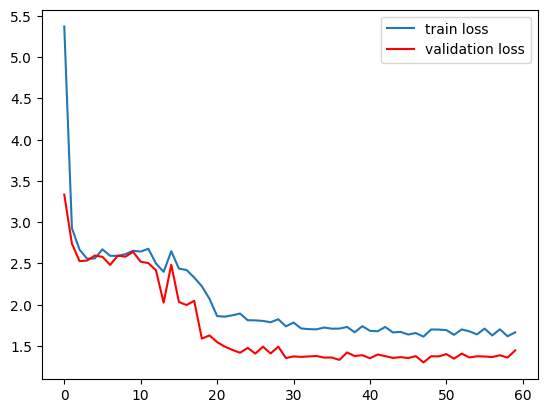

In [19]:
import matplotlib.pyplot as plt
plt.plot(losses_train, label='train loss')
plt.plot(losses_valid, label='validation loss', color='r')
plt.legend()

plt.show()